# Max Planck Institute Weather Station

https://www.kaggle.com/datasets/alistairking/weather-long-term-time-series-forecasting

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pandas import to_datetime
from statsmodels.tsa.stattools import adfuller
from pmdarima.arima import nsdiffs
from statsmodels.tsa.seasonal import seasonal_decompose, STL
import pmdarima as pm
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import durbin_watson

In [3]:
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter('ignore', ValueWarning)

## Dataset

| **Column Name** | **Description** |
|------------------|-----------------|
| `date` | Date and time of the observation. |
| `p` | Atmospheric pressure in millibars (mbar). |
| `T` | Air temperature in degrees Celsius (°C). |
| `Tpot` | Potential temperature in Kelvin (K), representing the temperature an air parcel would have if moved to a standard pressure level. |
| `Tdew` | Dew point temperature in degrees Celsius (°C), indicating the temperature at which air becomes saturated with moisture. |
| `rh` | Relative humidity as a percentage (%), showing the amount of moisture in the air relative to the maximum it can hold at that temperature. |
| `VPmax` | Maximum vapor pressure in millibars (mbar), representing the maximum pressure exerted by water vapor at the given temperature. |
| `VPact` | Actual vapor pressure in millibars (mbar), indicating the current water vapor pressure in the air. |
| `VPdef` | Vapor pressure deficit in millibars (mbar), measuring the difference between maximum and actual vapor pressure, used to gauge drying potential. |
| `sh` | Specific humidity in grams per kilogram (g/kg), showing the mass of water vapor per kilogram of air. |
| `H2OC` | Concentration of water vapor in millimoles per mole (mmol/mol) of dry air. |
| `rho` | Air density in grams per cubic meter (g/m³), reflecting the mass of air per unit volume. |
| `wv` | Wind speed in meters per second (m/s), measuring the horizontal motion of air. |
| `max. wv` | Maximum wind speed in meters per second (m/s), indicating the highest recorded wind speed over the period. |
| `wd` | Wind direction in degrees (°), representing the direction from which the wind is blowing. |
| `rain` | Total rainfall in millimeters (mm), showing the amount of precipitation over the observation period. |
| `raining` | Duration of rainfall in seconds (s), recording the time for which rain occurred during the observation period. |
| `SWDR` | Short-wave downward radiation in watts per square meter (W/m²), measuring incoming solar radiation. |
| `PAR` | Photosynthetically active radiation in micromoles per square meter per second (µmol/m²/s), indicating the amount of light available for photosynthesis. |
| `max. PAR` | Maximum photosynthetically active radiation recorded in the observation period in µmol/m²/s. |
| `Tlog` | Temperature logged in degrees Celsius (°C), potentially from a secondary sensor or logger. |
| `OT` | Likely refers to an "operational timestamp" or an offset in time, but may need clarification depending on the dataset's context. |


In [4]:
raw = pd.read_csv('data/cleaned_weather.csv')

raw

,date,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,...,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
0,2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,...,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45
1,2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,...,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51
2,2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,...,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60
3,2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,...,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70
4,2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,...,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52691,2020-12-31 23:20:00,978.32,2.28,277.16,-0.80,80.0,7.20,5.76,1.44,3.67,...,1234.61,0.73,1.40,180.6,0.0,0.0,0.0,0.0,0.0,13.40
52692,2020-12-31 23:30:00,978.30,2.13,277.01,-0.43,83.1,7.12,5.92,1.20,3.77,...,1235.20,0.43,0.82,174.0,0.0,0.0,0.0,0.0,0.0,13.42
52693,2020-12-31 23:40:00,978.26,1.99,276.88,-0.71,82.2,7.05,5.80,1.26,3.69,...,1235.82,0.38,0.76,248.9,0.0,0.0,0.0,0.0,0.0,13.45
52694,2020-12-31 23:50:00,978.26,2.07,276.95,-0.77,81.4,7.09,5.77,1.32,3.68,...,1235.49,0.57,1.07,196.6,0.0,0.0,0.0,0.0,0.0,13.47


In [5]:
# Convert 'datetime' to datetime type
raw['date'] = pd.to_datetime(raw['date'])

# Set as datetime index
raw.set_index('date', inplace=True)                  

# Display
raw.head()

,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
date,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45
2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51
2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60
2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70
2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81


In [6]:
raw.head(10)

,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
date,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:10:00,1008.89,0.71,273.18,-1.33,86.1,6.43,5.54,0.89,3.42,5.49,1280.62,1.02,1.60,224.3,0.0,0.0,0.0,0.0,0.0,11.45
2020-01-01 00:20:00,1008.76,0.75,273.22,-1.44,85.2,6.45,5.49,0.95,3.39,5.45,1280.33,0.43,0.84,206.8,0.0,0.0,0.0,0.0,0.0,11.51
2020-01-01 00:30:00,1008.66,0.73,273.21,-1.48,85.1,6.44,5.48,0.96,3.39,5.43,1280.29,0.61,1.48,197.1,0.0,0.0,0.0,0.0,0.0,11.60
2020-01-01 00:40:00,1008.64,0.37,272.86,-1.64,86.3,6.27,5.41,0.86,3.35,5.37,1281.97,1.11,1.48,206.4,0.0,0.0,0.0,0.0,0.0,11.70
2020-01-01 00:50:00,1008.61,0.33,272.82,-1.50,87.4,6.26,5.47,0.79,3.38,5.42,1282.08,0.49,1.40,209.6,0.0,0.0,0.0,0.0,0.0,11.81
2020-01-01 01:00:00,1008.44,0.34,272.84,-1.54,87.1,6.26,5.45,0.81,3.37,5.41,1281.84,0.63,1.32,188.0,0.0,0.0,0.0,0.0,0.0,11.91
2020-01-01 01:10:00,1008.49,0.19,272.69,-1.65,87.4,6.19,5.41,0.78,3.34,5.37,1282.63,0.88,1.28,195.4,0.0,0.0,0.0,0.0,0.0,12.00
2020-01-01 01:20:00,1008.40,0.03,272.53,-1.70,88.1,6.12,5.39,0.73,3.33,5.35,1283.30,1.05,1.64,183.1,0.0,0.0,0.0,0.0,0.0,12.07
2020-01-01 01:30:00,1008.29,0.11,272.63,-1.61,88.1,6.16,5.43,0.73,3.35,5.38,1282.73,0.90,1.72,199.9,0.0,0.0,0.0,0.0,0.0,12.12


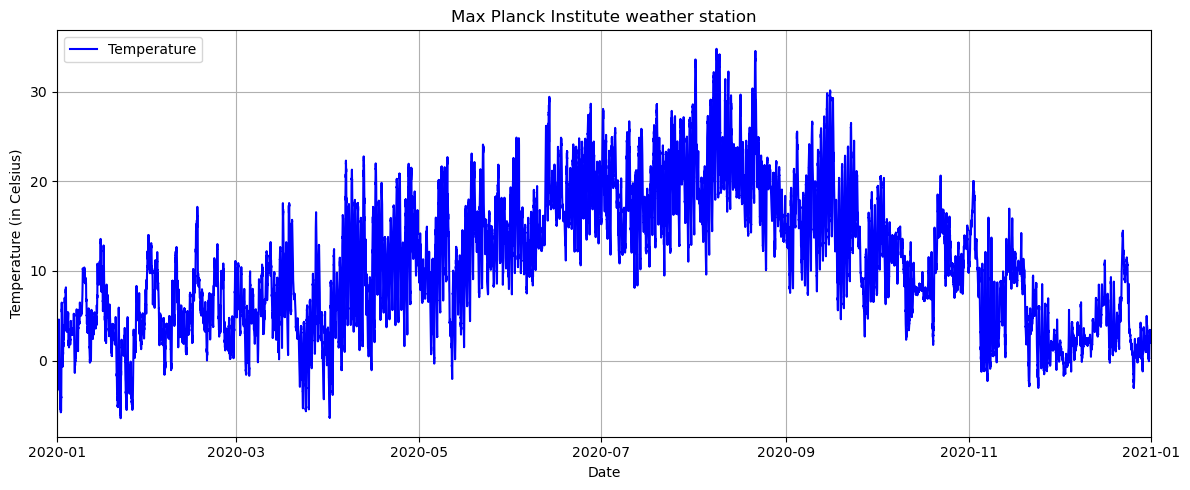

In [7]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 5))                                      

plt.plot(raw.index, raw['T'], label='Temperature', color='blue')     

plt.title('Max Planck Institute weather station')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (in Celsius)')  
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2021-01-01'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

In [8]:
# Aggregate the data by hour (mean for each hour)
raw_hourly = raw.resample('H').mean()

# Display the first few rows
raw_hourly.head()

,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
date,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,1008.712000,0.578000,273.058000,-1.478000,86.020000,6.370000,5.478000,0.890000,3.386000,5.432000,1281.058000,0.732000,1.360000,208.840000,0.0,0.0,0.0,0.0,0.0,11.614000
2020-01-01 01:00:00,1008.356667,0.141667,272.650000,-1.661667,87.600000,6.170000,5.405000,0.765000,3.338333,5.363333,1282.693333,0.781667,1.353333,177.800000,0.0,0.0,0.0,0.0,0.0,12.063333
2020-01-01 02:00:00,1008.333333,-0.153333,272.360000,-1.800000,88.583333,6.038333,5.350000,0.691667,3.306667,5.305000,1284.068333,0.510000,1.230000,169.363333,0.0,0.0,0.0,0.0,0.0,12.008333
2020-01-01 03:00:00,1008.166667,-0.615000,271.913333,-2.075000,89.783333,5.841667,5.243333,0.598333,3.241667,5.201667,1286.078333,0.908333,1.506667,185.701667,0.0,0.0,0.0,0.0,0.0,11.558333
2020-01-01 04:00:00,1007.898333,-1.416667,271.131667,-2.613333,91.500000,5.503333,5.036667,0.470000,3.115000,4.996667,1289.638333,1.008333,1.896667,166.433333,0.0,0.0,0.0,0.0,0.0,10.868333


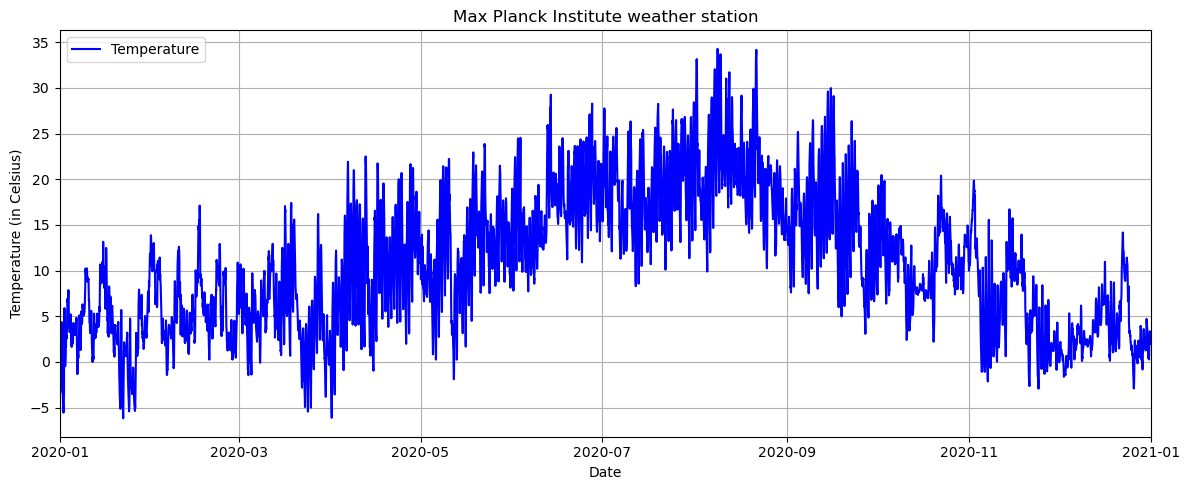

In [9]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 5))                                      

plt.plot(raw_hourly.index, raw_hourly['T'], label='Temperature', color='blue')     

plt.title('Max Planck Institute weather station')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (in Celsius)')  
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2021-01-01'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

In [10]:
# Aggregate the data by day (mean for each day)
raw_daily = raw.resample('D').mean()

# Display the first few rows of the daily-aggregated data
raw_daily.head()

,p,T,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,rho,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog
date,,,,,,,,,,,,,,,,,,,,
2020-01-01,1006.958811,-0.514196,272.106084,-2.569231,86.429301,5.961748,5.066923,0.894545,3.136154,5.031888,1284.242238,0.783287,1.456573,173.153846,0.000000,0.000000,57.698671,95.880979,99.195175,11.889720
2020-01-02,1001.050972,-1.056319,272.024167,-4.215069,80.206042,5.853056,4.513333,1.339722,2.809931,4.509653,1279.685069,1.173403,2.133542,165.250556,0.000000,0.000000,66.461389,96.849375,100.276042,11.303611
2020-01-03,993.802917,4.835278,278.491042,2.006806,81.975000,8.721319,7.114236,1.607569,4.465694,7.160069,1242.085694,3.927153,6.106319,192.667292,0.002083,14.375000,11.569375,25.155556,29.956111,14.310139
2020-01-04,998.244236,3.784931,277.084583,0.785764,80.899861,8.038264,6.485694,1.553333,4.050694,6.497083,1252.611111,2.261667,4.695347,248.491667,0.033333,41.805556,8.040208,18.851875,21.601319,13.970833
2020-01-05,1007.105347,2.735000,275.336458,-1.018611,76.422639,7.446458,5.682292,1.764861,3.516319,5.641458,1268.925139,1.791528,2.812431,220.305556,0.000000,0.000000,31.750208,65.250694,77.068194,13.938264


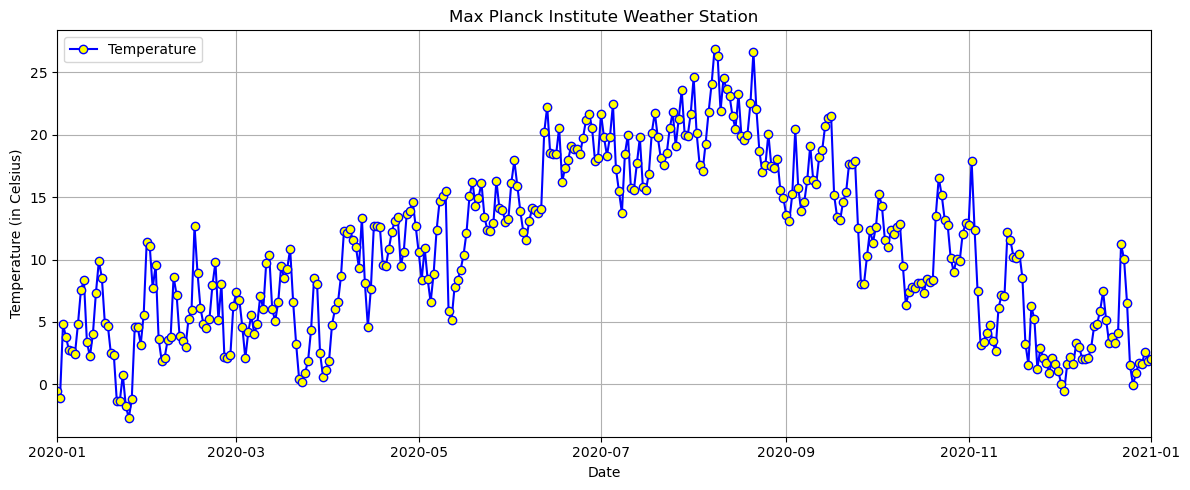

In [11]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 5))                                      

plt.plot(raw_daily.index, raw_daily['T'], label='Temperature', color='blue', marker='o', markerfacecolor='yellow')     

plt.title('Max Planck Institute Weather Station')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (in Celsius)')  
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2021-01-01'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

In [12]:
# Rename 'meantemp' to 'temp'
raw_daily.rename(columns={'T': 'temp'}, inplace=True)  

raw_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 367 entries, 2020-01-01 to 2021-01-01
Freq: D
Data columns (total 20 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   p         367 non-null    float64
 1   temp      367 non-null    float64
 2   Tpot      367 non-null    float64
 3   Tdew      367 non-null    float64
 4   rh        367 non-null    float64
 5   VPmax     367 non-null    float64
 6   VPact     367 non-null    float64
 7   VPdef     367 non-null    float64
 8   sh        367 non-null    float64
 9   H2OC      367 non-null    float64
 10  rho       367 non-null    float64
 11  wv        367 non-null    float64
 12  max. wv   367 non-null    float64
 13  wd        367 non-null    float64
 14  rain      367 non-null    float64
 15  raining   367 non-null    float64
 16  SWDR      367 non-null    float64
 17  PAR       367 non-null    float64
 18  max. PAR  367 non-null    float64
 19  Tlog      367 non-null    float64
dtypes: fl

# SARIMA

### Split in Train & Test datasets

In [13]:
# Split the data
cutoff = pd.to_datetime("2020-12-01")

train = raw_daily[raw_daily.index < cutoff]
test = raw_daily[raw_daily.index >= cutoff]

# Show results
print("Train shape:", train.shape)
print("Test shape:", test.shape)
print()
print(train.tail())
print()
print(test.head())

Train shape: (335, 20)
Test shape: (32, 20)

                     p      temp        Tpot      Tdew         rh     VPmax  \
date                                                                          
2020-11-26  995.202292  2.097639  275.626528  1.070278  93.252778  7.228819   
2020-11-27  994.694097  1.722361  275.290625  0.762639  93.846528  7.011181   
2020-11-28  996.630139  0.926111  274.340069 -0.247292  92.313819  6.547500   
2020-11-29  999.143194  2.156111  275.372986 -1.610347  76.485139  7.145694   
2020-11-30  996.848611  1.611736  275.010000 -2.028542  77.290903  6.894167   

               VPact     VPdef        sh      H2OC          rho        wv  \
date                                                                        
2020-11-26  6.645903  0.582917  4.164444  6.678264  1256.503472  1.454375   
2020-11-27  6.476319  0.534236  4.059931  6.511042  1257.625000  0.814444   
2020-11-28  6.011667  0.535764  3.760764  6.032292  1263.878056  1.720139   
2020-11-29  5.43

In [14]:
tem_series = train['temp']

len(tem_series)

335

### Find 'd'

In [15]:
def determine_nonseasonal_d(series, max_d=2, alpha=0.05):

    d = 0

    adf_result = adfuller(series)                # Run ADF test on the original series
    p_value = adf_result[1]
    print(f"d = {d} | ADF Statistic = {adf_result[0]:.4f}, p-value = {p_value:.4f}")

    if p_value < alpha:                          # If the original series is stationary
        
        return d
        
    else:
        while p_value > alpha and d < max_d:
            d += 1
            series = np.diff(series, n=1)        # Perform first-order differencing
            ad_fuller_result1 = adfuller(series)  
            p_value = ad_fuller_result1[1]
            print(f"d = {d} | ADF Statistic = {ad_fuller_result1[0]:.4f}, p-value = {p_value:.4f}")   
            
        return d  


d = determine_nonseasonal_d(tem_series)
print(f"\nNon-seasonal differencing term (d): {d}")

d = 0 | ADF Statistic = -1.3945, p-value = 0.5849
d = 1 | ADF Statistic = -8.0121, p-value = 0.0000

Non-seasonal differencing term (d): 1


### Find 'S'

In [16]:
def detect_seasonal(series):

    # Apply Fourier Transform
    fourier = np.fft.fft(series - np.mean(series))
    frequencies = np.fft.fftfreq(len(series))

    # Identify the most significant frequency (ignoring the 0 frequency)
    positive_freqs = frequencies[np.where(frequencies > 0)]
    significant_freq = positive_freqs[np.argmax(np.abs(fourier[1:len(positive_freqs)+1]))]

    # Calculate the seasonal period (S)
    S = int(1 / significant_freq)

    return print(f"Detected Seasonal Period: S = {S}")

detect_seasonal(tem_series)

Detected Seasonal Period: S = 335


### Check possible S's

In [17]:
def detect_top_seasonal_periods(series, top_n=5):
    import numpy as np
    import pandas as pd

    # Remove mean to center the series
    series_detrended = series - np.mean(series)

    # Apply Fourier Transform
    fourier = np.fft.fft(series_detrended)
    frequencies = np.fft.fftfreq(len(series))

    # Only keep positive frequencies (exclude zero)
    positive_mask = frequencies > 0
    positive_freqs = frequencies[positive_mask]
    magnitudes = np.abs(fourier[positive_mask])

    # Get indices of top N magnitudes
    top_indices = np.argsort(magnitudes)[-top_n:][::-1]

    # Prepare result
    top_periods = [(round(1 / positive_freqs[i], 2), magnitudes[i]) for i in top_indices]

    # Display results
    print("Top Seasonal Periods (in time units):")
    for i, (period, magnitude) in enumerate(top_periods, 1):
        print(f"{i}. Period = {period} (Frequency = {round(positive_freqs[top_indices[i-1]], 5)}), Magnitude = {round(magnitude, 2)}")


detect_top_seasonal_periods(tem_series, top_n=10)

Top Seasonal Periods (in time units):
1. Period = 335.0 (Frequency = 0.00299), Magnitude = 1343.36
2. Period = 22.33 (Frequency = 0.04478), Magnitude = 241.44
3. Period = 167.5 (Frequency = 0.00597), Magnitude = 202.69
4. Period = 67.0 (Frequency = 0.01493), Magnitude = 166.48
5. Period = 13.96 (Frequency = 0.07164), Magnitude = 150.09
6. Period = 20.94 (Frequency = 0.04776), Magnitude = 144.1
7. Period = 37.22 (Frequency = 0.02687), Magnitude = 141.56
8. Period = 11.17 (Frequency = 0.08955), Magnitude = 137.49
9. Period = 47.86 (Frequency = 0.0209), Magnitude = 131.69
10. Period = 7.61 (Frequency = 0.13134), Magnitude = 125.12


### Find 'D'

In [18]:
def determine_seasonal_D(series, m=12):
    
    # Get seasonal differencing terms using CH and OCSB tests
    D = max(nsdiffs(series, m=m, test='ch'),
            nsdiffs(series, m=m, test='ocsb'))

    return D

for m in  [7, 30, 52]:

    D = determine_seasonal_D(tem_series, m)
    print(f'Seasonal differencing term (D) for {m}: {D}')

Seasonal differencing term (D) for 7: 0
Seasonal differencing term (D) for 30: 0
Seasonal differencing term (D) for 52: 0


In [19]:
print('                Canova-Hansen test:', nsdiffs(tem_series, m=22, test='ch'))
print('Osborn-Chui-Smith-Birchenhall test:', nsdiffs(tem_series, m=22, test='ocsb'))

                Canova-Hansen test: 0
Osborn-Chui-Smith-Birchenhall test: 0


### Seasonal Decomposition

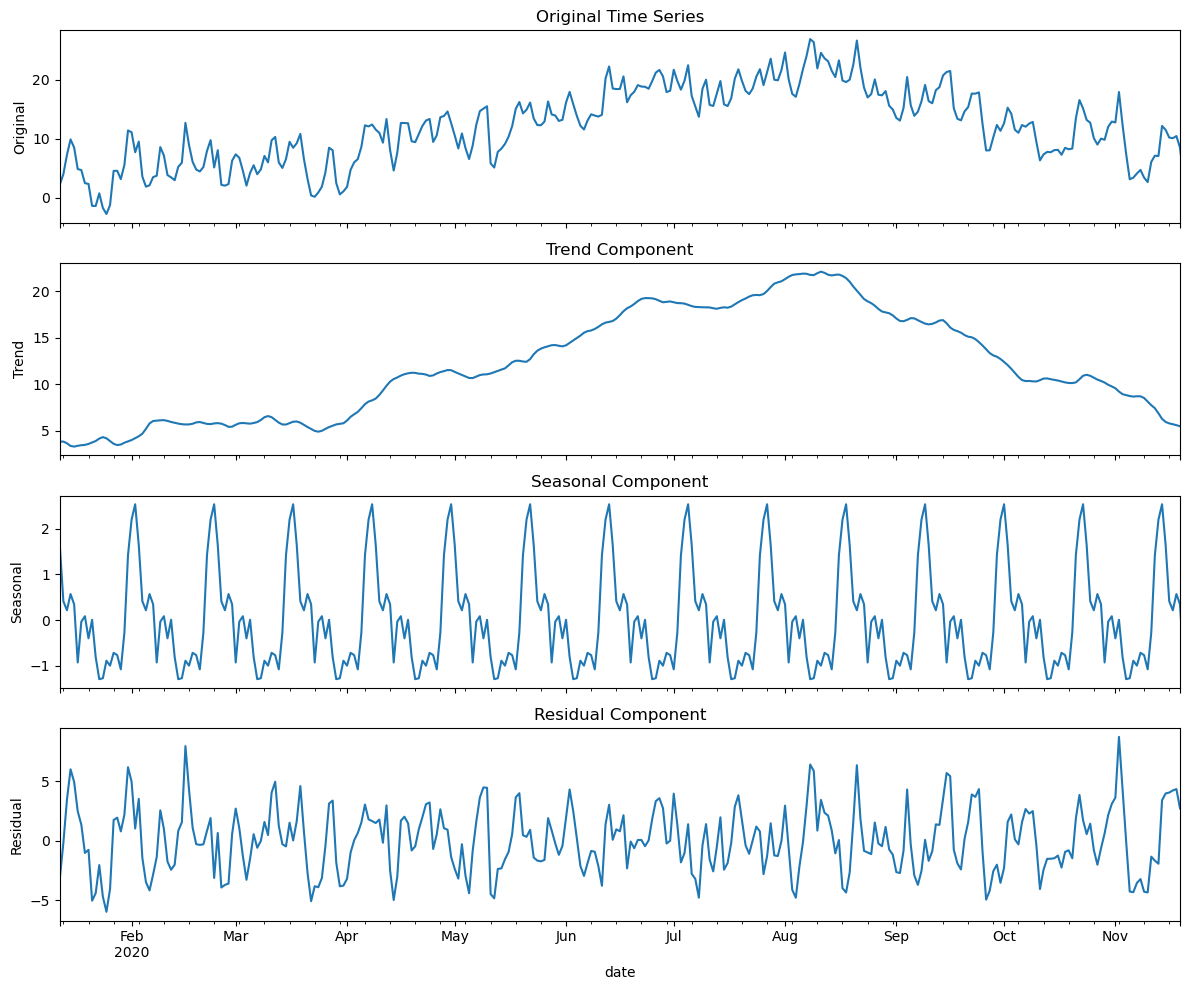

In [20]:
result = seasonal_decompose(tem_series, model='aditive', period=22)

trend = result.trend.dropna()
seasonal = result.seasonal.dropna()
residual = result.resid.dropna()


# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

result.observed.plot(ax=axes[0], title="Original Time Series")
axes[0].set_ylabel('Original')

trend.plot(ax=axes[1], title="Trend Component")
axes[1].set_ylabel('Trend')

seasonal.plot(ax=axes[2], title="Seasonal Component")
axes[2].set_ylabel('Seasonal')

residual.plot(ax=axes[3], title="Residual Component")
axes[3].set_ylabel('Residual')

plt.tight_layout()
plt.show()

### Fourier Transformation, K=2: Exogenous Variable

Approximate equation:
 y(t) = 11.51 + -6.16 * cos(2 * pi * 0.00299 * t) + -5.14 * sin(2 * pi * 0.00299 * t)

Length of fourier_train: 335
Length of fourier_test: 32


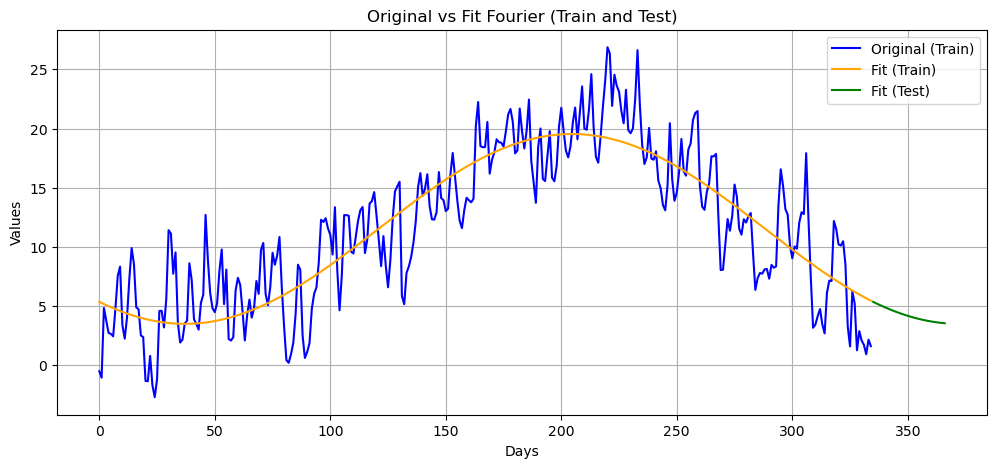

In [21]:
# Data for training
N_train = train.shape[0]      # Number of days in training
t_train = np.arange(N_train)  # Index of days
S = 22                        # Seasonality
 
# DFT application
fourier = np.fft.fft(tem_series)
frequencies = np.fft.fftfreq(N_train)

# Positive frequencies
positive_freqs = frequencies[:N_train//2]
fourier_positive = fourier[:N_train//2]

# Find the dominant frequencies (relative to S=365)
K = 2                                                              # Number of harmonics
dominant_indices = np.argsort(np.abs(fourier_positive))[::-1][:K]  # Top K frequencies
dominant_freqs = positive_freqs[dominant_indices]
dominant_amplitudes = fourier_positive[dominant_indices]

# Reconstruct the equation
a0 = np.mean(tem_series)                  # DC component (mean)
equation_terms = [f"{a0:.2f}"]            # Constant term
for i, (freq, amp) in enumerate(zip(dominant_freqs, dominant_amplitudes)):
    a_k = (2 * np.real(amp)) / N_train    # Cosine coefficient
    b_k = (-2 * np.imag(amp)) / N_train   # Sine coefficient
    if freq > 0:                          # Ignore zero frequency
        term = f"{a_k:.2f} * cos(2 * pi * {freq:.5f} * t) + {b_k:.2f} * sin(2 * pi * {freq:.5f} * t)"
        equation_terms.append(term)

# Final Equation
equation = "y(t) = " + " + ".join(equation_terms)
print("Approximate equation:\n", equation)
print()

# Reconstruct the adjusted series for training
y_fit_train = np.zeros(N_train)
y_fit_train += a0
for freq, amp in zip(dominant_freqs, dominant_amplitudes):
    y_fit_train += (2 * np.real(amp) / N_train) * np.cos(2 * np.pi * freq * t_train) + (-2 * np.imag(amp) / N_train) * np.sin(2 * np.pi * freq * t_train)

# Correct the vertical offset
offset = np.mean(y_fit_train) - np.mean(tem_series)
y_fit_corrected_train = y_fit_train - offset

# Extrapolate for test set
N_test = test.shape[0]
t_test = np.arange(N_train, N_train + N_test)  # New time indices for test
y_fit_test = np.zeros(N_test)
y_fit_test += a0
for freq, amp in zip(dominant_freqs, dominant_amplitudes):
    y_fit_test += (2 * np.real(amp) / N_train) * np.cos(2 * np.pi * freq * t_test) + (-2 * np.imag(amp) / N_train) * np.sin(2 * np.pi * freq * t_test)

# Assign to fourier_train and fourier_test
fourier_train = y_fit_corrected_train
fourier_test = y_fit_test - offset  # Apply the same offset for consistency

# Print lengths
print("Length of fourier_train:", len(fourier_train))
print("Length of fourier_test:", len(fourier_test))

# Optional: Plot to verify
plt.figure(figsize=(12, 5))
plt.plot(t_train, tem_series, label='Original (Train)', color='blue')
plt.plot(t_train, fourier_train, label='Fit (Train)', color='orange')
plt.plot(t_test, fourier_test, label='Fit (Test)', color='green')
#plt.plot(t_test, test['temp'], label='Fit (Test)', color='black')
plt.legend()
plt.grid(True)
plt.title('Original vs Fit Fourier (Train and Test)')
plt.xlabel('Days')
plt.ylabel('Values')
plt.show()

In [22]:
train['Fourier'] = fourier_train
test['Fourier'] = fourier_test

train.head()

,p,temp,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,...,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog,Fourier
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1006.958811,-0.514196,272.106084,-2.569231,86.429301,5.961748,5.066923,0.894545,3.136154,5.031888,...,0.783287,1.456573,173.153846,0.000000,0.000000,57.698671,95.880979,99.195175,11.889720,5.355846
2020-01-02,1001.050972,-1.056319,272.024167,-4.215069,80.206042,5.853056,4.513333,1.339722,2.809931,4.509653,...,1.173403,2.133542,165.250556,0.000000,0.000000,66.461389,96.849375,100.276042,11.303611,5.260591
2020-01-03,993.802917,4.835278,278.491042,2.006806,81.975000,8.721319,7.114236,1.607569,4.465694,7.160069,...,3.927153,6.106319,192.667292,0.002083,14.375000,11.569375,25.155556,29.956111,14.310139,5.167536
2020-01-04,998.244236,3.784931,277.084583,0.785764,80.899861,8.038264,6.485694,1.553333,4.050694,6.497083,...,2.261667,4.695347,248.491667,0.033333,41.805556,8.040208,18.851875,21.601319,13.970833,5.076713
2020-01-05,1007.105347,2.735000,275.336458,-1.018611,76.422639,7.446458,5.682292,1.764861,3.516319,5.641458,...,1.791528,2.812431,220.305556,0.000000,0.000000,31.750208,65.250694,77.068194,13.938264,4.988156


In [23]:
test.head()

,p,temp,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,...,wv,max. wv,wd,rain,raining,SWDR,PAR,max. PAR,Tlog,Fourier
date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,989.553611,1.059931,275.034167,0.127778,93.564583,6.602778,6.178889,0.423472,3.892431,6.243472,...,2.079861,3.044861,182.306250,0.00625,105.347222,13.208264,28.116528,30.956597,11.972847,5.355846
2020-12-02,990.670694,0.036111,273.919236,-0.807222,94.267292,6.134792,5.805625,0.329097,3.652708,5.859167,...,1.555139,2.237986,127.190139,0.00000,0.000000,21.904722,43.642153,47.632014,10.560903,5.260591
2020-12-03,978.896875,-0.489653,274.330486,-3.847708,77.938333,5.900486,4.600000,1.300417,2.928681,4.700486,...,3.318611,5.021111,189.882639,0.00000,0.000000,14.610139,30.600764,32.792083,9.583542,5.167536
2020-12-04,966.843403,1.654653,277.468056,-2.481042,74.185625,6.927708,5.099236,1.828403,3.287361,5.274097,...,2.421528,3.714583,180.408958,0.00000,0.000000,28.799931,56.380417,64.718403,11.789722,5.076713
2020-12-05,972.713750,2.186944,277.523403,-0.138681,84.772639,7.196458,6.059931,1.136458,3.882986,6.228056,...,1.437153,2.447847,187.866181,0.00000,6.875000,17.580417,35.473611,41.289028,12.332361,4.988156


### Model

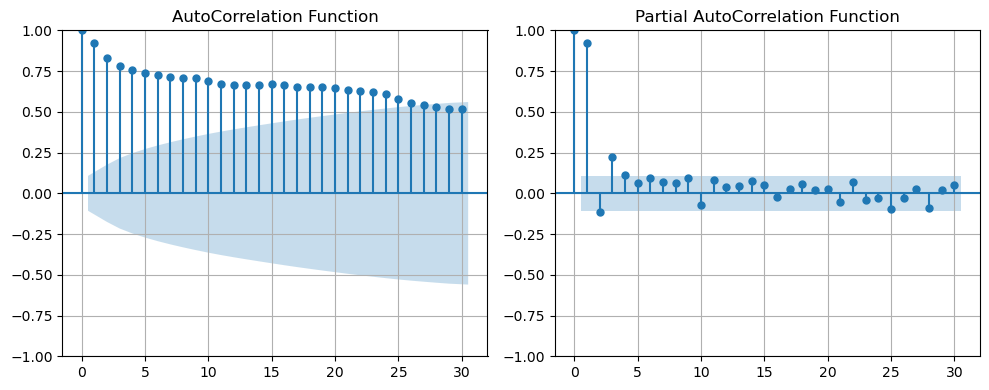

In [24]:
def acf_and_pacf(series, lagsn=15):

    # Create a 1x2 grid for subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))  

    # Plot AutoCorrelation Function
    plot_acf(series, ax=axes[0], lags=lagsn)
    axes[0].set_title("AutoCorrelation Function", fontsize=12)
    axes[0].grid(True)

    # Plot Partial Autocorrelation Function
    plot_pacf(series, ax=axes[1], lags=lagsn)
    axes[1].set_title("Partial AutoCorrelation Function", fontsize=12)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


acf_and_pacf(tem_series, lagsn=30)

In [25]:
def best_auto_arima(series, d=0, D=0, S=12):

    # Perform a full search over the same grid as your manual SARIMAX model
    auto_model = pm.auto_arima(
        series,                     # The time series data
        seasonal=True,              # Enable seasonal component
        m=S,                        # Seasonal period
        d=d,                        # Set differencing 
        D=D,                        # Set seasonal differencing
        start_p=0, max_p=3,         # p 
        start_q=0, max_q=3,         # q 
        start_P=0, max_P=3,         # P 
        start_Q=0, max_Q=3,         # Q 
        stepwise=False,             # Disable stepwise search (enable full grid search)
        trace=False,                # Print model search progress
        error_action='ignore',      # Ignore errors and continue
        suppress_warnings=True,     # Suppress convergence warnings
        information_criterion='aic' # Use AIC to choose the best model
    )

    # Print the best model found
    print(f"Best model: SARIMA{auto_model.order}{auto_model.seasonal_order}")

best_auto_arima(tem_series, d=1, D=0, S=22)

Best model: SARIMA(0, 1, 3)(1, 0, 0, 22)


In [26]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]       # Generate Cartesian product of input lists
    return combo                                         # Return the list of combinations


def find_best(series, d=0, D=0, S=12):

    P_ns, Q_ns = [0, 1, 2, 3], [0, 1, 2, 3]              # Define search ranges for non-seasonal parameters (p, q)
    P_s, Q_s = [0, 1, 2, 3], [0, 1, 2, 3]                # Define search ranges for seasonal parameters (P, Q)


    total = len(P_ns) * len(Q_ns) * len(P_s) * len(Q_s)
    print(f'Total number of models: {total}')

    vals = combinator([P_ns, [d], Q_ns, P_s, [D], Q_s])  # Generate all combinations of SARIMA parameter sets

    score = {}                                           # Dictionary to store model evaluation metrics

    for i, (p, d, q, P, D, Q) in enumerate(vals):        # Iterate over all parameter combinations
    
        if i % 15 == 0:                                  # Print progress every 15 models
            print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},{S})')

        m = SARIMAX(series,                              # Define SARIMA model with current parameter set
                    order=(p,d,q), 
                    seasonal_order=(P, D, Q, S),   
                    enforce_stationarity=False)          # Allow non-stationary models for broader search

        res = m.fit(disp=0, low_memory=True)             # Fit the model silently

        score[i] = {                                     # Store model results and evaluation metrics
            'non-seasonal order': (p, d, q),      
            'seasonal order': (P, D, Q),
            'AIC': res.aic,                              # Akaike Information Criterion
        }
        
    print("\nBest models by AIC:")
    best_models = pd.DataFrame(score).T.sort_values(by='AIC').reset_index().head()
    print(best_models)


find_best(series=tem_series, d=1, D=0, S=22)

Total number of models: 256
Running model #0 using SARIMA(0,1,0)(0,0,0,22)
Running model #15 using SARIMA(0,1,0)(3,0,3,22)
Running model #30 using SARIMA(0,1,1)(3,0,2,22)
Running model #45 using SARIMA(0,1,2)(3,0,1,22)
Running model #60 using SARIMA(0,1,3)(3,0,0,22)
Running model #75 using SARIMA(1,1,0)(2,0,3,22)
Running model #90 using SARIMA(1,1,1)(2,0,2,22)
Running model #105 using SARIMA(1,1,2)(2,0,1,22)
Running model #120 using SARIMA(1,1,3)(2,0,0,22)
Running model #135 using SARIMA(2,1,0)(1,0,3,22)
Running model #150 using SARIMA(2,1,1)(1,0,2,22)
Running model #165 using SARIMA(2,1,2)(1,0,1,22)
Running model #180 using SARIMA(2,1,3)(1,0,0,22)
Running model #195 using SARIMA(3,1,0)(0,0,3,22)
Running model #210 using SARIMA(3,1,1)(0,0,2,22)
Running model #225 using SARIMA(3,1,2)(0,0,1,22)
Running model #240 using SARIMA(3,1,3)(0,0,0,22)
Running model #255 using SARIMA(3,1,3)(3,0,3,22)

Best models by AIC:
   index non-seasonal order seasonal order          AIC
0     51          (0,

In [27]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_013 = SARIMAX(endog=train['temp'],            # Time series data
                    order=(0, 1, 3),                # Non-seasonal order (p,d,q)
                    seasonal_order=(1, 0, 3, 22),   # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_013 = model_013.fit()

# Display summary of the model
print(model_fit_013.summary())

                                     SARIMAX Results                                      
Dep. Variable:                               temp   No. Observations:                  335
Model:             SARIMAX(0, 1, 3)x(1, 0, 3, 22)   Log Likelihood                -582.246
Date:                            Tue, 27 May 2025   AIC                           1180.491
Time:                                    09:29:45   BIC                           1209.099
Sample:                                01-01-2020   HQIC                          1191.986
                                     - 11-30-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0196      0.062      0.313      0.754      -0.103       0.142
ma.L2         -0.3844      0.064   

In [28]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_013)

ma.L1 coefficient: 0.0196
ma.L1 95% CI: (-0.1029, 0.1420)
ma.L1 p-value: 0.7540
ma.L1 is statistically IRRELEVANT in the model.

ar.S.L22 coefficient: 0.0478
ar.S.L22 95% CI: (-0.3758, 0.4714)
ar.S.L22 p-value: 0.8251
ar.S.L22 is statistically IRRELEVANT in the model.

ma.S.L22 coefficient: -0.0209
ma.S.L22 95% CI: (-0.4656, 0.4237)
ma.S.L22 p-value: 0.9264
ma.S.L22 is statistically IRRELEVANT in the model.

ma.S.L44 coefficient: 0.0373
ma.S.L44 95% CI: (-0.1189, 0.1934)
ma.S.L44 p-value: 0.6399
ma.S.L44 is statistically IRRELEVANT in the model.

ma.S.L66 coefficient: 0.0572
ma.S.L66 95% CI: (-0.0872, 0.2016)
ma.S.L66 p-value: 0.4372
ma.S.L66 is statistically IRRELEVANT in the model.



In [29]:
# Define the SARIMA (p,d,q)(P,D,Q,S) model
model_000 = SARIMAX(endog=train['temp'],            # Time series data
                    exog=train[['Fourier']],        # Seasonal component
                    order=(0, 1, 3),                # Non-seasonal order (p,d,q)
                    seasonal_order=(0, 0, 0, 22),   # Seasonal order (P,D,Q,S)
                    enforce_stationarity=False)     # Allow non-stationary behavior

# Fit the model
model_fit_000 = model_000.fit()

# Display summary of the model
print(model_fit_000.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  335
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -733.061
Date:                Tue, 27 May 2025   AIC                           1476.122
Time:                        09:29:46   BIC                           1495.117
Sample:                    01-01-2020   HQIC                          1483.699
                         - 11-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Fourier        1.0077      0.066     15.317      0.000       0.879       1.137
ma.L1         -0.1061      0.054     -1.976      0.048      -0.211      -0.001
ma.L2         -0.4848      0.052     -9.269      0.0

In [30]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_000)

All variables are statistically relevant.


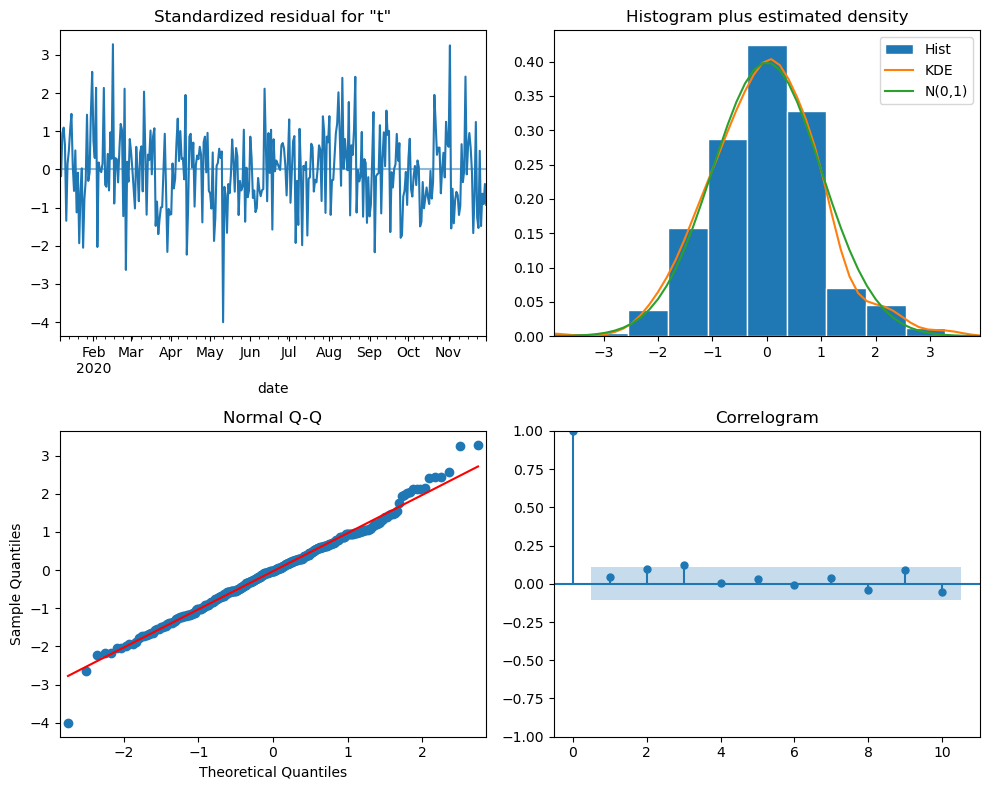

In [31]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_000.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [32]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_000.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.569337,0.450523
2,2.279128,0.319958
3,7.083595,0.069281
4,7.084489,0.131490
5,7.601989,0.179578
6,7.611353,0.267981
7,8.011655,0.331567
8,9.236295,0.322756
9,11.558298,0.239371
10,12.139491,0.275829


In [33]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.8937
Conclusion: No significant autocorrelation.


In [34]:
# Must match the structure of training exog
exog_test_S = test[['Fourier']] 

# Forecast the next Time points with exogenous inputs
forecast_S = model_fit_000.get_forecast(steps=test.shape[0], exog=exog_test_S)

# Extract predicted mean and confidence intervals
forecast_mean_S = forecast_S.predicted_mean
conf_int_S = forecast_S.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast S'] = forecast_mean_S.values
test['Error S'] = test['Forecast S'] - test['temp']
test['Lower 95% CI S'] = conf_int_S.iloc[:, 0].values
test['Upper 95% CI S'] = conf_int_S.iloc[:, 1].values

# Display updated test DataFrame
test.head()

,p,temp,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,...,raining,SWDR,PAR,max. PAR,Tlog,Fourier,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S
date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,989.553611,1.059931,275.034167,0.127778,93.564583,6.602778,6.178889,0.423472,3.892431,6.243472,...,105.347222,13.208264,28.116528,30.956597,11.972847,5.355846,2.924175,1.864244,-1.429646,7.277995
2020-12-02,990.670694,0.036111,273.919236,-0.807222,94.267292,6.134792,5.805625,0.329097,3.652708,5.859167,...,0.000000,21.904722,43.642153,47.632014,10.560903,5.260591,4.154342,4.118231,-1.685589,9.994273
2020-12-03,978.896875,-0.489653,274.330486,-3.847708,77.938333,5.900486,4.600000,1.300417,2.928681,4.700486,...,0.000000,14.610139,30.600764,32.792083,9.583542,5.167536,4.859615,5.349268,-1.246070,10.965301
2020-12-04,966.843403,1.654653,277.468056,-2.481042,74.185625,6.927708,5.099236,1.828403,3.287361,5.274097,...,0.000000,28.799931,56.380417,64.718403,11.789722,5.076713,4.768091,3.113438,-1.338297,10.874478
2020-12-05,972.713750,2.186944,277.523403,-0.138681,84.772639,7.196458,6.059931,1.136458,3.882986,6.228056,...,6.875000,17.580417,35.473611,41.289028,12.332361,4.988156,4.678848,2.491904,-1.428243,10.785939


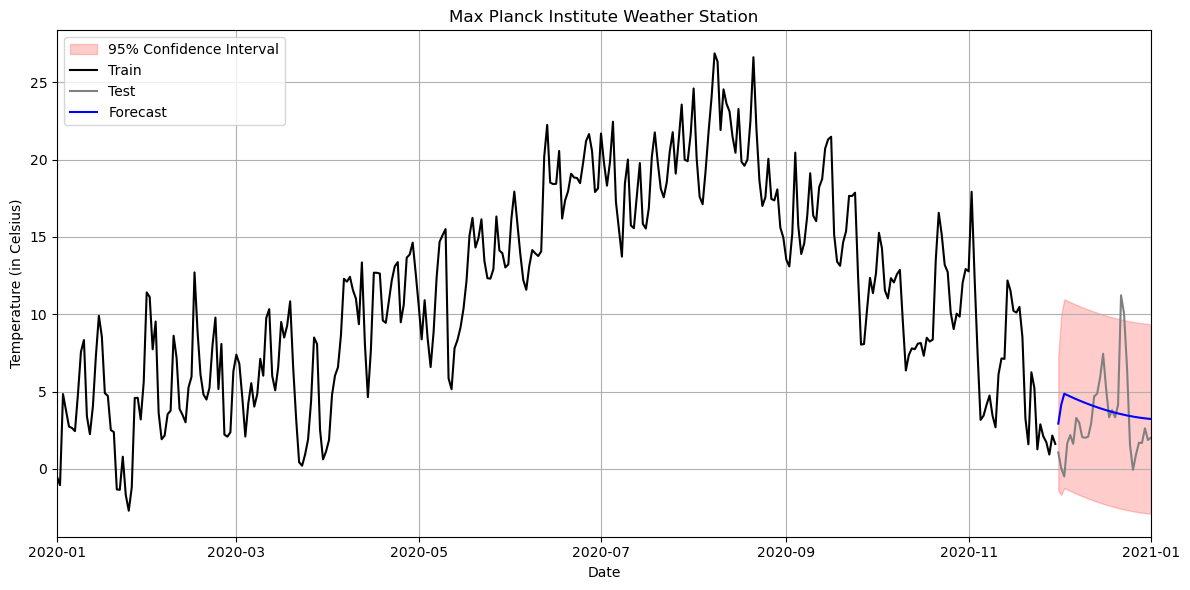

In [35]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_S.iloc[:, 0],     # Lower bound
                 conf_int_S.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['temp'], label='Train', color='black')           # Train
plt.plot(test.index, test['temp'], label='Test', color='gray')               # Test
plt.plot(test.index, test['Forecast S'], label='Forecast', color='blue')     # Forecast

plt.title('Max Planck Institute Weather Station')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (in Celsius)')  
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2021-01-01'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

# SARIMAX Model with Exogenous Variables

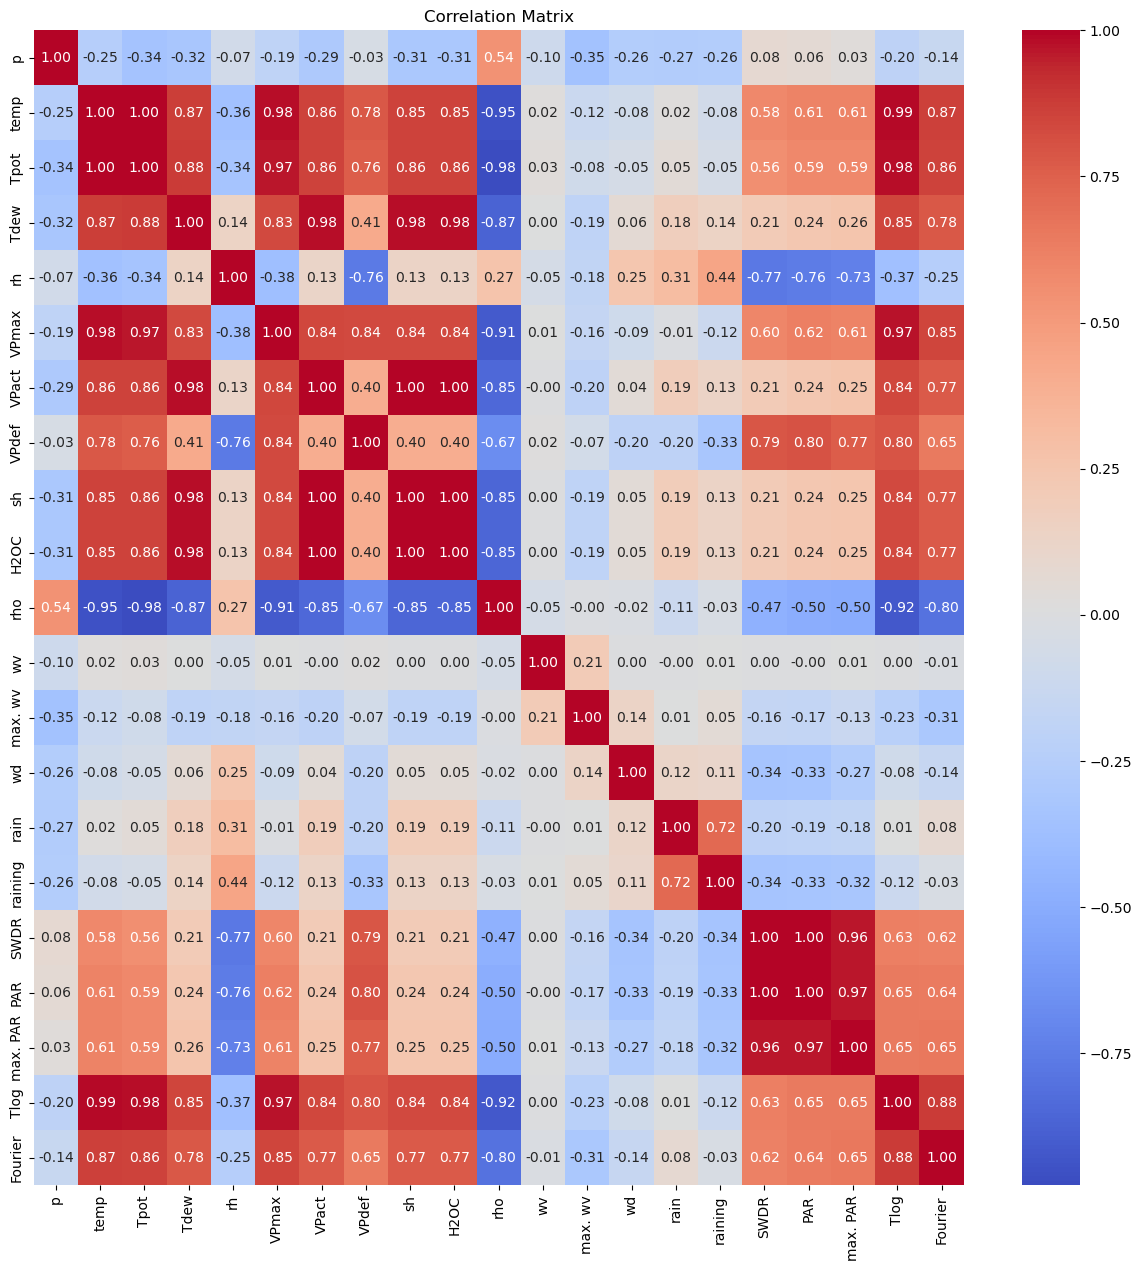

In [36]:
# Compute correlation matrix
c_matrix = train.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(c_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [37]:
# Identify columns where the first row value is >= 0.7 or <= -0.7
selected_columns = c_matrix.columns[np.logical_or(c_matrix.iloc[1] >= 0.70, 
                                                  c_matrix.iloc[1] <= -0.70)]

# Convert to list and remove target series
filtered_columns = [col for col in selected_columns if col != 'temp']

# Show the result
print(filtered_columns)

['Tpot', 'Tdew', 'VPmax', 'VPact', 'VPdef', 'sh', 'H2OC', 'rho', 'Tlog', 'Fourier']


| **Column Name** | **Description** |
|------------------|-----------------|
| `date` | Date and time of the observation. |
| `p` | Atmospheric pressure in millibars (mbar). |
| `T` | Air temperature in degrees Celsius (°C). |
| `Tpot` | Potential temperature in Kelvin (K), representing the temperature an air parcel would have if moved to a standard pressure level. |
| `Tdew` | Dew point temperature in degrees Celsius (°C), indicating the temperature at which air becomes saturated with moisture. |
| `rh` | Relative humidity as a percentage (%), showing the amount of moisture in the air relative to the maximum it can hold at that temperature. |
| `VPmax` | Maximum vapor pressure in millibars (mbar), representing the maximum pressure exerted by water vapor at the given temperature. |
| `VPact` | Actual vapor pressure in millibars (mbar), indicating the current water vapor pressure in the air. |
| `VPdef` | Vapor pressure deficit in millibars (mbar), measuring the difference between maximum and actual vapor pressure, used to gauge drying potential. |
| `sh` | Specific humidity in grams per kilogram (g/kg), showing the mass of water vapor per kilogram of air. |
| `H2OC` | Concentration of water vapor in millimoles per mole (mmol/mol) of dry air. |
| `rho` | Air density in grams per cubic meter (g/m³), reflecting the mass of air per unit volume. |
| `wv` | Wind speed in meters per second (m/s), measuring the horizontal motion of air. |
| `max. wv` | Maximum wind speed in meters per second (m/s), indicating the highest recorded wind speed over the period. |
| `wd` | Wind direction in degrees (°), representing the direction from which the wind is blowing. |
| `rain` | Total rainfall in millimeters (mm), showing the amount of precipitation over the observation period. |
| `raining` | Duration of rainfall in seconds (s), recording the time for which rain occurred during the observation period. |
| `SWDR` | Short-wave downward radiation in watts per square meter (W/m²), measuring incoming solar radiation. |
| `PAR` | Photosynthetically active radiation in micromoles per square meter per second (µmol/m²/s), indicating the amount of light available for photosynthesis. |
| `max. PAR` | Maximum photosynthetically active radiation recorded in the observation period in µmol/m²/s. |
| `Tlog` | Temperature logged in degrees Celsius (°C), potentially from a secondary sensor or logger. |
| `OT` | Likely refers to an "operational timestamp" or an offset in time, but may need clarification depending on the dataset's context. |

In [38]:
# Create candidates dataframe
candidates = train[['Tpot', 'Tdew', 'VPmax', 'VPact', 'VPdef', 'sh', 'H2OC', 'rho', 'Tlog', 'Fourier']]

# Compute correlation matrix
corr_candidates = candidates.corr()

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = corr_candidates.columns
vif_data["VIF"] = [round(variance_inflation_factor(corr_candidates.values, i), 2) for i in range(len(corr_candidates.columns))]

# Define VIF interpretation rules
conditions = [
    (vif_data["VIF"] < 5),
    (vif_data["VIF"] >= 5) & (vif_data["VIF"] <= 10),
    (vif_data["VIF"] > 10)
]
choices = [
    "Not Multicollinearity",
    "Moderate Multicollinearity",
    "High Multicollinearity"
]

# Add interpretation column
vif_data["Interpretation"] = np.select(conditions, choices, default="Undefined")

# Make 'Feature' as Index
vif_data.set_index('Feature', inplace=True)

# Display VIF results
print(vif_data)
print()

# Compute and display correlation matrix
corr = corr_candidates.corr().round(2)
print(f'Correlation:\n{corr}')

                  VIF          Interpretation
Feature                                      
Tpot     9.085033e+08  High Multicollinearity
Tdew     1.347971e+10  High Multicollinearity
VPmax             inf  High Multicollinearity
VPact             inf  High Multicollinearity
VPdef             inf  High Multicollinearity
sh       2.144571e+14  High Multicollinearity
H2OC     1.286743e+14  High Multicollinearity
rho      2.912894e+08  High Multicollinearity
Tlog     6.850989e+07  High Multicollinearity
Fourier  7.896409e+07  High Multicollinearity

Correlation:
         Tpot  Tdew  VPmax  VPact  VPdef    sh  H2OC   rho  Tlog  Fourier
Tpot     1.00  0.96   1.00   0.96   0.89  0.96  0.96 -1.00  1.00     0.99
Tdew     0.96  1.00   0.95   1.00   0.72  1.00  1.00 -0.97  0.95     0.95
VPmax    1.00  0.95   1.00   0.94   0.91  0.94  0.94 -0.99  1.00     0.99
VPact    0.96  1.00   0.94   1.00   0.71  1.00  1.00 -0.97  0.95     0.95
VPdef    0.89  0.72   0.91   0.71   1.00  0.71  0.71 -0.86  0.90

### Gauger Test

In [40]:
def prepare_granger_data_multi(y, X, d=0, D=0, S=12):

    # Apply seasonal differencing D times to y and all columns in X
    for _ in range(D):
        y = y.diff(S)
        X = X.diff(S)

    # Apply regular differencing d times
    for _ in range(d):
        y = y.diff()
        X = X.diff()

    # Drop missing values
    y = y.dropna()
    X = X.dropna()

    # Concatenate and align
    df = pd.concat([y] + [X[col] for col in X.columns], axis=1).dropna()
    df.columns = [y.name] + list(X.columns)

    return df


# Assume y is a Series and X is a DataFrame with multiple exogenous variables
y = train['temp']
X = train[['Tpot', 'Tdew', 'VPmax', 'VPact', 'VPdef', 'sh', 'H2OC', 'rho', 'Tlog', 'Fourier']]

# Prepare data
df_granger = prepare_granger_data_multi(y, X, d=1, D=0, S=365)

# Test each exogenous variable separately
from statsmodels.tsa.stattools import grangercausalitytests

for col in X.columns:
    print(f"\nTesting if {col} Granger-causes {y.name}")
    #grangercausalitytests(df_granger[[y.name, col]], maxlag=7, verbose=True)


Testing if Tpot Granger-causes temp

Testing if Tdew Granger-causes temp

Testing if VPmax Granger-causes temp

Testing if VPact Granger-causes temp

Testing if VPdef Granger-causes temp

Testing if sh Granger-causes temp

Testing if H2OC Granger-causes temp

Testing if rho Granger-causes temp

Testing if Tlog Granger-causes temp

Testing if Fourier Granger-causes temp


In [41]:
from statsmodels.tsa.stattools import grangercausalitytests

def summarize_granger_results(df, target_col, maxlag=7, alpha=0.05):

    results = []

    # Loop through all exogenous variables
    for col in df.columns:
        if col == target_col:
            continue  # skip the dependent variable

        # Run Granger test
        test_result = grangercausalitytests(df[[target_col, col]], maxlag=maxlag, verbose=False)

        # Extract p-values from ssr_chi2test for each lag
        p_values = [round(test_result[lag][0]['ssr_chi2test'][1], 4) for lag in range(1, maxlag+1)]

        # Find best (lowest) p-value and corresponding lag
        min_p = min(p_values)
        best_lag = p_values.index(min_p) + 1  # lags start at 1

        # Flag if variable Granger-causes the target
        granger_causes = 'Yes' if min_p < alpha else 'No'

        results.append({
            'Exogenous Variable': col,
            'Min p-value': min_p,
            'Best Lag': best_lag,
            'Granger-Causes ' + target_col: granger_causes
        })

    # Convert to DataFrame and set index
    summary_df = pd.DataFrame(results)
    summary_df.set_index('Exogenous Variable', inplace=True)

    return summary_df

# df_granger deve conter target + exógenas
summary = summarize_granger_results(df_granger, target_col='temp', maxlag=7)
summary

,Min p-value,Best Lag,Granger-Causes temp
Exogenous Variable,,,
Tpot,0.0012,7,Yes
Tdew,0.0832,1,No
VPmax,0.1600,7,No
VPact,0.1512,1,No
VPdef,0.1843,1,No
sh,0.1288,1,No
H2OC,0.1280,1,No
rho,0.0017,1,Yes
Tlog,0.3188,2,No


In [42]:
# Multiple column selection
exog_data = train[['Fourier','rho']]  

# Target variable selection
endog_data = train['temp']        

In [43]:
# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                  exog=exog_data, 
                  order=(0, 1, 3),               
                  seasonal_order=(0, 0, 0, 22),    
                  enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  335
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -483.391
Date:                Tue, 27 May 2025   AIC                            978.782
Time:                        09:29:47   BIC                           1001.577
Sample:                    01-01-2020   HQIC                           987.875
                         - 11-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Fourier        0.3039      0.336      0.905      0.365      -0.354       0.962
rho           -0.1551      0.003    -45.224      0.000      -0.162      -0.148
ma.L1          0.0282      0.050      0.562      0.5

In [44]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_M)

Fourier coefficient: 0.3039
Fourier 95% CI: (-0.3543, 0.9620)
Fourier p-value: 0.3655
Fourier is statistically IRRELEVANT in the model.

ma.L1 coefficient: 0.0282
ma.L1 95% CI: (-0.0702, 0.1266)
ma.L1 p-value: 0.5740
ma.L1 is statistically IRRELEVANT in the model.



In [45]:
# Multiple column selection
exog_data = train[['rho']]  

# Target variable selection
endog_data = train['temp']

# Define the SARIMAX model with exogenous regressors
model_M = SARIMAX(endog=endog_data, 
                  exog=exog_data, 
                  order=(0, 1, 3),               
                  seasonal_order=(0, 0, 0, 22),    
                  enforce_stationarity=False)

# Fit the model
model_fit_M = model_M.fit()

# Display model summary
print(model_fit_M.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  335
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -483.857
Date:                Tue, 27 May 2025   AIC                            977.714
Time:                        09:29:47   BIC                            996.709
Sample:                    01-01-2020   HQIC                           985.291
                         - 11-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
rho           -0.1554      0.003    -44.848      0.000      -0.162      -0.149
ma.L1          0.0336      0.050      0.667      0.505      -0.065       0.132
ma.L2         -0.2624      0.057     -4.595      0.0

In [46]:
def test_parameters(model):

    # Identify irrelevant variables: exclude sigma2
    exo_vars = [name for name in model.params.index if name != 'sigma2']

    # Extract confidence intervals
    conf_int = model.conf_int()
    irrelevant_found = False  # Flag to track if any irrelevant variable is found

    # Loop through each parameter
    for var in exo_vars:
        lower, upper = conf_int.loc[var]
        p_val = model.pvalues[var]

        # If CI includes 0 and p-value > 0.05 → irrelevant
        if lower < 0 < upper and p_val > 0.05:
            coef = model.params[var]
            print(f"{var} coefficient: {coef:.4f}")
            print(f"{var} 95% CI: ({lower:.4f}, {upper:.4f})")
            print(f"{var} p-value: {p_val:.4f}")
            print(f"{var} is statistically IRRELEVANT in the model.\n")
            irrelevant_found = True

    # If no irrelevant variables are found
    if not irrelevant_found:
        print("All variables are statistically relevant.")

# Test with the model
test_parameters(model_fit_M)

ma.L1 coefficient: 0.0336
ma.L1 95% CI: (-0.0651, 0.1322)
ma.L1 p-value: 0.5046
ma.L1 is statistically IRRELEVANT in the model.



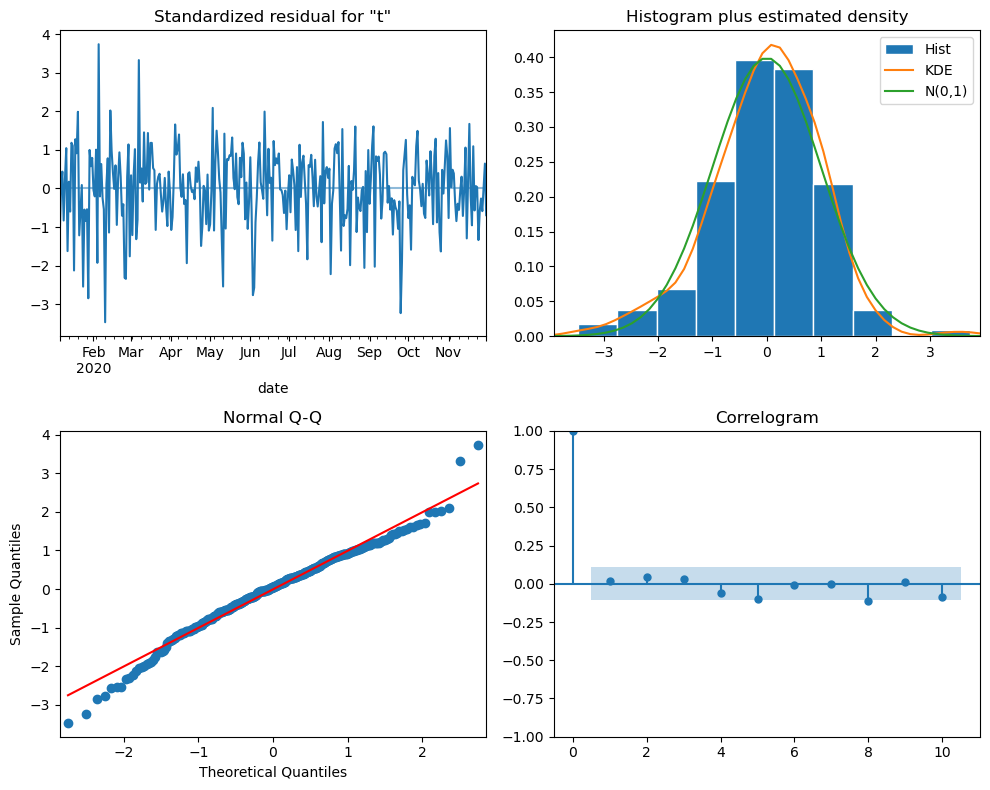

In [47]:
# Diagnostic plots for the model, including residuals and other model checks
model_fit_M.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show();

In [48]:
# Extract the residuals (errors) from the fitted model
residuals = model_fit_M.resid  

# Apply the Ljung-Box test on the residuals, on 10 lags.
df_residuals = acorr_ljungbox(residuals, np.arange(1, 11, 1))

# Check if all values in 'lb_pvalue' are lower than 0.05
if (df_residuals['lb_pvalue'] > 0.05).all():
    print('All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.\n')
else:
    print('There are p-values < 0.05; Ha: Residuals are autocorrelated.\n')

# Show Residuals
df_residuals

All p-values > 0.05; H0: Residuals are independently distributed and uncorrelated.



,lb_stat,lb_pvalue
1,0.012598,0.910633
2,0.012712,0.993664
3,0.016173,0.999456
4,0.032135,0.999872
5,0.050863,0.999970
6,0.050869,0.999997
7,0.052503,1.000000
8,0.062840,1.000000
9,0.063376,1.000000
10,0.070907,1.000000


In [49]:
# Dublin-Watson Test
dw_statistic = durbin_watson(residuals)

print(f'Durbin-Watson statistic: {dw_statistic:.4f}')

# Automatic conclusion based on the DW statistic
if dw_statistic < 0.5:
    print("Conclusion: Strong Positive autocorrelation.")
elif 0.5 <= dw_statistic <= 1.5:
    print("Conclusion: Evidence of positive autocorrelation.")
elif 1.5 <= dw_statistic <= 2.5:
    print("Conclusion: No significant autocorrelation.")
elif 2.5 <= dw_statistic <= 3.5:
    print("Conclusion: Evidence of negative autocorrelation.")
elif dw_statistic > 3.5:
    print("Conclusion: Strong negative autocorrelation.")

Durbin-Watson statistic: 1.0214
Conclusion: Evidence of positive autocorrelation.


In [50]:
# Must match the structure of training exog
exog_test_M = test[['rho']] 

# Forecast the next Time points with exogenous inputs
forecast_M = model_fit_M.get_forecast(steps=test.shape[0], exog=exog_test_M)

# Extract predicted mean and confidence intervals
forecast_mean_M = forecast_M.predicted_mean
conf_int_M = forecast_M.conf_int()

# Assign forecasts to the test DataFrame
test['Forecast M'] = forecast_mean_M.values
test['Error M'] = test['Forecast M'] - test['temp']
test['Lower 95% CI M'] = conf_int_M.iloc[:, 0].values
test['Upper 95% CI M'] = conf_int_M.iloc[:, 1].values

# Display updated test DataFrame
test.head()

,p,temp,Tpot,Tdew,rh,VPmax,VPact,VPdef,sh,H2OC,...,Tlog,Fourier,Forecast S,Error S,Lower 95% CI S,Upper 95% CI S,Forecast M,Error M,Lower 95% CI M,Upper 95% CI M
date,,,,,,,,,,,,,,,,,,,,,
2020-12-01,989.553611,1.059931,275.034167,0.127778,93.564583,6.602778,6.178889,0.423472,3.892431,6.243472,...,11.972847,5.355846,2.924175,1.864244,-1.429646,7.277995,2.527613,1.467682,0.473215,4.582011
2020-12-02,990.670694,0.036111,273.919236,-0.807222,94.267292,6.134792,5.805625,0.329097,3.652708,5.859167,...,10.560903,5.260591,4.154342,4.118231,-1.685589,9.994273,1.612590,1.576479,-1.341949,4.567128
2020-12-03,978.896875,-0.489653,274.330486,-3.847708,77.938333,5.900486,4.600000,1.300417,2.928681,4.700486,...,9.583542,5.167536,4.859615,5.349268,-1.246070,10.965301,3.615745,4.105397,0.263240,6.968249
2020-12-04,966.843403,1.654653,277.468056,-2.481042,74.185625,6.927708,5.099236,1.828403,3.287361,5.274097,...,11.789722,5.076713,4.768091,3.113438,-1.338297,10.874478,7.537854,5.883201,3.977110,11.098599
2020-12-05,972.713750,2.186944,277.523403,-0.138681,84.772639,7.196458,6.059931,1.136458,3.882986,6.228056,...,12.332361,4.988156,4.678848,2.491904,-1.428243,10.785939,6.826979,4.640034,3.069518,10.584440


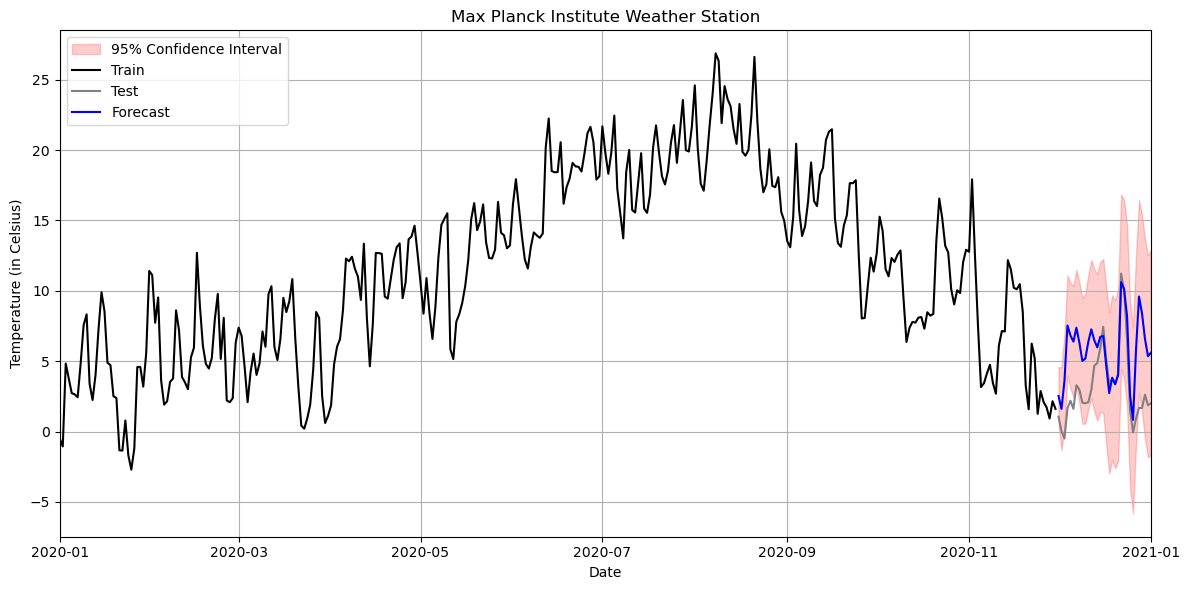

In [51]:
# Plot actual and fitted serie
plt.figure(figsize=(12, 6))                                      

# Plot 95% confidence interval
plt.fill_between(test.index,
                 conf_int_M.iloc[:, 0],     # Lower bound
                 conf_int_M.iloc[:, 1],     # Upper bound
                 color='red', alpha=0.2, label='95% Confidence Interval')

plt.plot(train.index, train['temp'], label='Train', color='black')           # Train
plt.plot(test.index, test['temp'], label='Test', color='gray')               # Test
plt.plot(test.index, test['Forecast M'], label='Forecast', color='blue')     # Forecast

plt.title('Max Planck Institute Weather Station')                      
plt.xlabel('Date')                                        
plt.ylabel('Temperature (in Celsius)')  
plt.xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2021-01-01'))
#plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation on y-axis
plt.grid(True)                                            
plt.legend(loc=2)                                             
plt.tight_layout()                                       
plt.show()

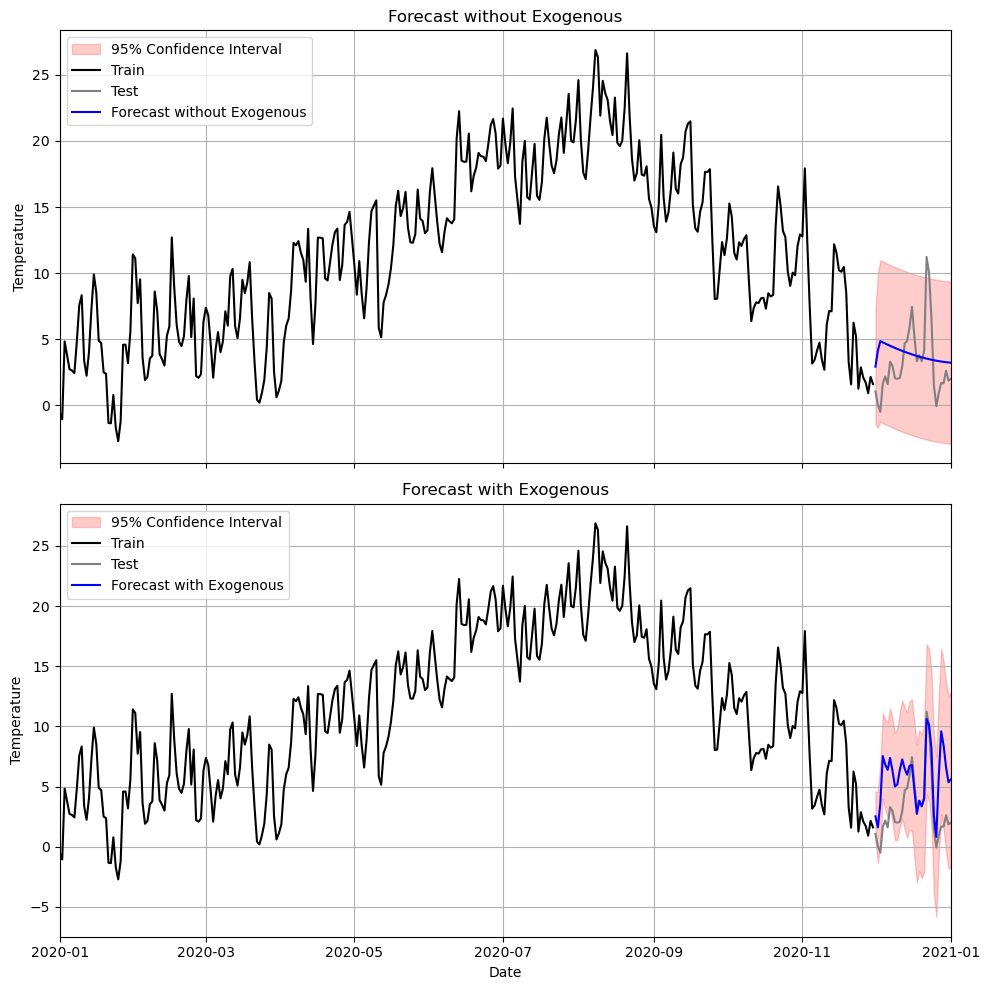

In [52]:
# Create subplots: 2 rows, 1 column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10), sharex=True)

# --- First Forecast (Forecast S) ---
axes[0].fill_between(test.index,
                     conf_int_S.iloc[:, 0],
                     conf_int_S.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[0].plot(train.index, train['temp'], label='Train', color='black')
axes[0].plot(test.index, test['temp'], label='Test', color='gray')
axes[0].plot(test.index, test['Forecast S'], label='Forecast without Exogenous', color='blue')

axes[0].set_title('Forecast without Exogenous')
axes[0].set_ylabel('Temperature')
axes[0].legend(loc=2)
axes[0].grid(True)
axes[0].set_xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2021-01-01'))
#axes[0].set_ylim(5, 40)

# --- Second Forecast (Forecast M) ---
axes[1].fill_between(test.index,
                     conf_int_M.iloc[:, 0],
                     conf_int_M.iloc[:, 1],
                     color='red', alpha=0.2, label='95% Confidence Interval')

axes[1].plot(train.index, train['temp'], label='Train', color='black')
axes[1].plot(test.index, test['temp'], label='Test', color='gray')
axes[1].plot(test.index, test['Forecast M'], label='Forecast with Exogenous', color='blue')

axes[1].set_title('Forecast with Exogenous')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Temperature')
axes[1].legend(loc=2)
axes[1].grid(True)
axes[1].set_xlim(pd.to_datetime('2020-01-01'), pd.to_datetime('2021-01-01'))
#axes[1].set_ylim(5, 40)

# Final layout
plt.tight_layout()
plt.show()

In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error


# Metrics for Forecast without Exo
mae_s = mean_absolute_error(test['temp'], test['Forecast S'])
rmse_s = np.sqrt(mean_squared_error(test['temp'], test['Forecast S']))
mape_s = mean_absolute_percentage_error(test['temp'], test['Forecast S']) * 100

# Metrics for Forecast with Exo
mae_m = mean_absolute_error(test['temp'], test['Forecast M'])
rmse_m = np.sqrt(mean_squared_error(test['temp'], test['Forecast M']))
mape_m = mean_absolute_percentage_error(test['temp'], test['Forecast M']) * 100

# Combine into dictionaries
metrics_S = {
    'MAE': mae_s,
    'RMSE': rmse_s,
    #'MAPE': mape_s,
}
metrics_M = {
    'MAE': mae_m,
    'RMSE': rmse_m,
    #'MAPE': mape_m,
}

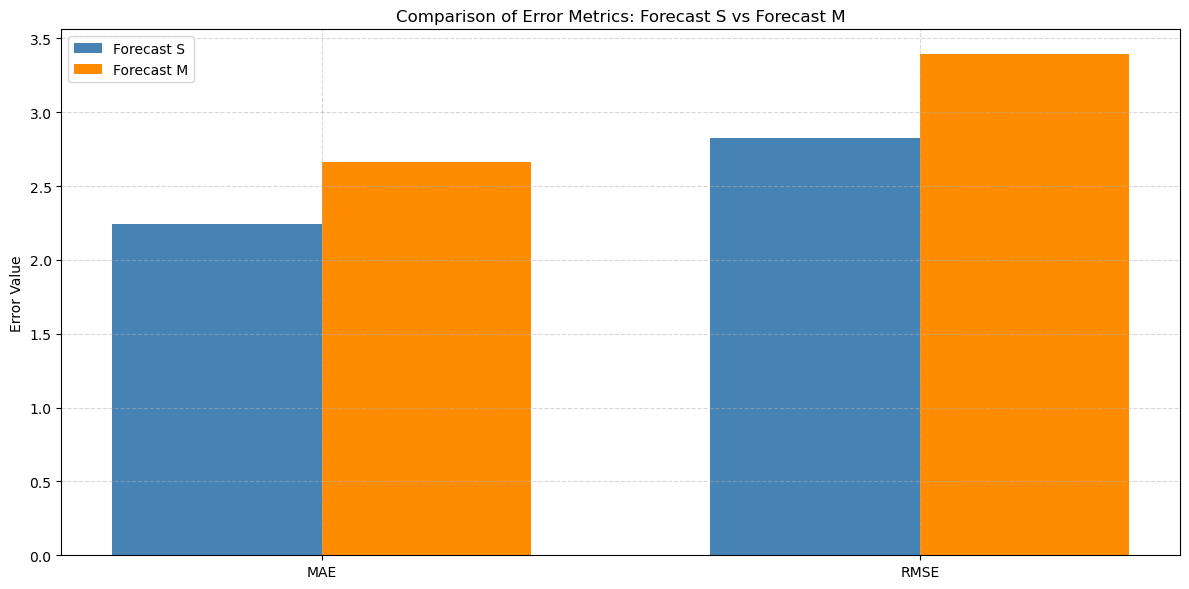

In [54]:
# Plotting
labels = list(metrics_S.keys())
values_S = list(metrics_S.values())
values_M = list(metrics_M.values())

x = range(len(labels))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar([i - width/2 for i in x], values_S, width=width, label='Forecast S', color='steelblue')
plt.bar([i + width/2 for i in x], values_M, width=width, label='Forecast M', color='darkorange')

plt.xticks(x, labels)
plt.ylabel("Error Value")
plt.title("Comparison of Error Metrics: Forecast S vs Forecast M")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [55]:
# Create DataFrame for Error Analysis
comparison_df = pd.DataFrame([metrics_S, metrics_M], index=['Forecast S', 'Forecast M']).T.round(2) 
comparison_df

,Forecast S,Forecast M
MAE,2.24,2.66
RMSE,2.83,3.39


    The model with only the endogenous variable (temp) and the Fourier transformation performed better than the model with the best exogenous variable (rho) as support.

End.